In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      # transforms.CenterCrop(26),
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                      #  transforms.RandomErasing(p=0.5),
                                       transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


In [4]:
SEED = 1
batch_size = 128
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, train_losses, train_acc, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, test_losses, test_acc):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_loss

In [6]:
from model import FinalNet
model = FinalNet().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
       BatchNorm2d-7           [-1, 20, 24, 24]              40
           Dropout-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 10, 10, 10]             900
             ReLU-12           [-1, 10, 10, 10]               0
      BatchNorm2d-13           [-1, 10, 10, 10]              20
          Dropout-14           [-1, 10,

To Get the requied accuracy, add more augmentation and change the LR schedular.

In [7]:
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

model = FinalNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, train_losses, train_acc, epoch)
    test_loss = test(model, device, test_loader, test_losses, test_acc)
    scheduler.step(test_loss)

EPOCH: 0


Loss=0.18185167014598846 Batch_id=468 Accuracy=91.94: 100%|██████████| 469/469 [00:52<00:00,  8.88it/s]



Test set: Average loss: 0.0540, Accuracy: 9835/10000 (98.35%)

EPOCH: 1


Loss=0.10498245805501938 Batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:49<00:00,  9.54it/s]



Test set: Average loss: 0.0404, Accuracy: 9861/10000 (98.61%)

EPOCH: 2


Loss=0.018548589199781418 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:49<00:00,  9.39it/s]



Test set: Average loss: 0.0292, Accuracy: 9901/10000 (99.01%)

EPOCH: 3


Loss=0.10837457329034805 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:48<00:00,  9.67it/s]



Test set: Average loss: 0.0286, Accuracy: 9905/10000 (99.05%)

EPOCH: 4


Loss=0.0662652775645256 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:49<00:00,  9.53it/s]



Test set: Average loss: 0.0288, Accuracy: 9912/10000 (99.12%)

EPOCH: 5


Loss=0.09588473290205002 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:50<00:00,  9.38it/s]



Test set: Average loss: 0.0230, Accuracy: 9917/10000 (99.17%)

EPOCH: 6


Loss=0.057007089257240295 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:47<00:00,  9.80it/s]



Test set: Average loss: 0.0262, Accuracy: 9917/10000 (99.17%)

EPOCH: 7


Loss=0.04078292101621628 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:47<00:00,  9.83it/s]



Test set: Average loss: 0.0250, Accuracy: 9918/10000 (99.18%)

Epoch 00008: reducing learning rate of group 0 to 1.0000e-02.
EPOCH: 8


Loss=0.03606594726443291 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:48<00:00,  9.59it/s]



Test set: Average loss: 0.0183, Accuracy: 9946/10000 (99.46%)

EPOCH: 9


Loss=0.026862910017371178 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:47<00:00,  9.83it/s]



Test set: Average loss: 0.0178, Accuracy: 9941/10000 (99.41%)

EPOCH: 10


Loss=0.11085561662912369 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:49<00:00,  9.39it/s]



Test set: Average loss: 0.0166, Accuracy: 9944/10000 (99.44%)

EPOCH: 11


Loss=0.017167173326015472 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:50<00:00,  9.33it/s]



Test set: Average loss: 0.0168, Accuracy: 9941/10000 (99.41%)

EPOCH: 12


Loss=0.004334533587098122 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:50<00:00,  9.30it/s]



Test set: Average loss: 0.0173, Accuracy: 9943/10000 (99.43%)

Epoch 00013: reducing learning rate of group 0 to 1.0000e-03.
EPOCH: 13


Loss=0.0035374723374843597 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:50<00:00,  9.20it/s]



Test set: Average loss: 0.0170, Accuracy: 9944/10000 (99.44%)

EPOCH: 14


Loss=0.016817329451441765 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:51<00:00,  9.17it/s]



Test set: Average loss: 0.0169, Accuracy: 9945/10000 (99.45%)

Epoch 00015: reducing learning rate of group 0 to 1.0000e-04.


Text(0.5, 1.0, 'Test Accuracy')

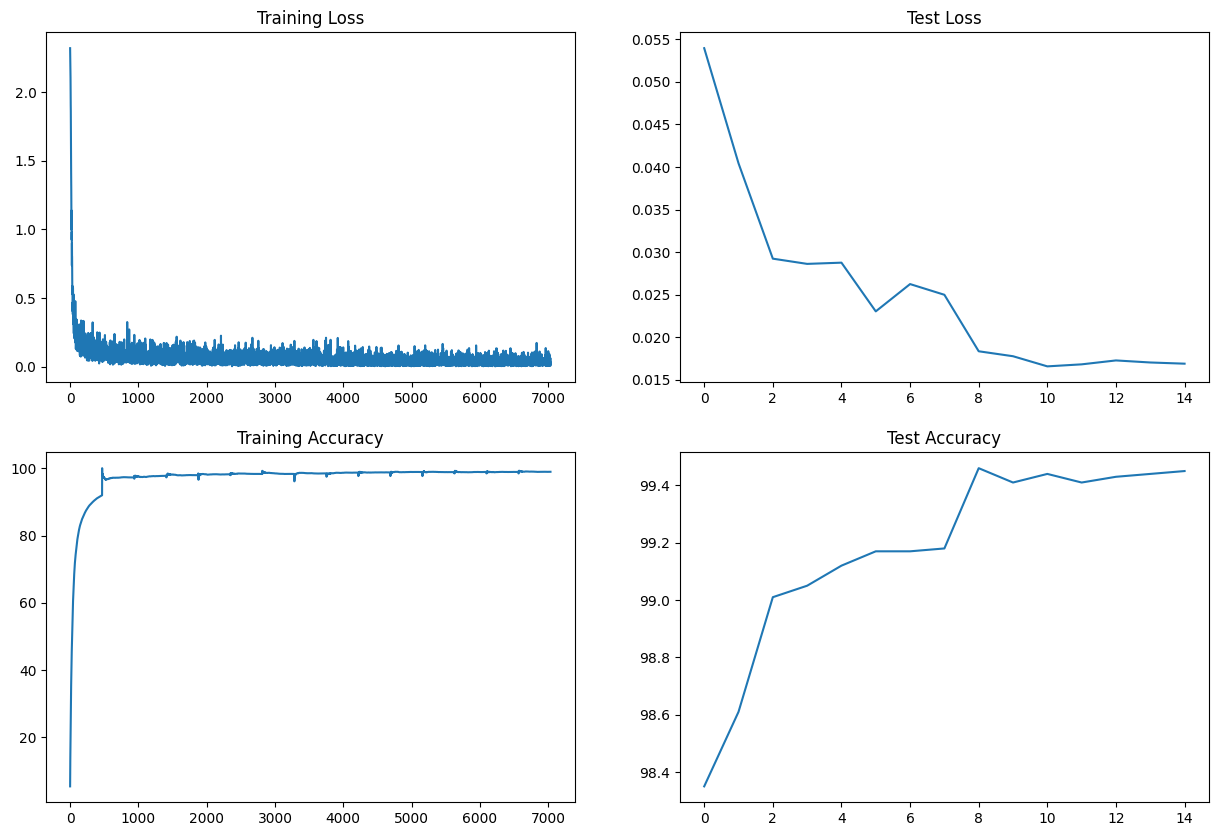

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([i.item() for i in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot([i for i in test_losses])
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")